<a href="https://colab.research.google.com/github/Suraba03/ml_san_francisco_permits/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime as dt

Import dataset from google drive

In [40]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/san_francisco/Building_Permits.csv', low_memory=False)

In [41]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [42]:
df.sample(5)

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
23568,201309035843,8,otc alterations permit,09/03/2013,3608,029,851,NaN,Guerrero,St,0.0,NaN,rear stair dry rot repair & replace inkind 49%...,complete,11/15/2013,09/03/2013,09/03/2013,11/15/2013,09/03/2013,NaN,3.0,3.0,NaN,NaN,08/29/2014,5000.0,5000.0,apartments,14.0,apartments,14.0,0.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,8.0,Mission,94110.0,"(37.7574300088584, -122.42308169331292)",1316276404729
185765,201710121126,8,otc alterations permit,10/12/2017,1456,007,445,NaN,24th,Av,0.0,NaN,soft story retrofit per sfebc chapter 4d engin...,filed,10/12/2017,10/12/2017,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,55000.0,0.0,apartments,10.0,apartments,10.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,1.0,Outer Richmond,94121.0,"(37.781173439465036, -122.48406951625532)",1483185410713
167024,M881547,8,otc alterations permit,01/26/2018,4207,013,1176,NaN,Florida,St,NaN,NaN,street space,issued,01/26/2018,01/26/2018,01/26/2018,NaN,01/26/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,Mission,94110.0,"(37.75313041152787, -122.41038100110683)",1494918389932
85559,201505136212,8,otc alterations permit,05/13/2015,1630,009,647,NaN,14th,Av,NaN,NaN,"remodel bath, upgrade elect, relocate laundry,...",complete,10/15/2015,05/13/2015,05/13/2015,10/15/2015,05/13/2015,NaN,3.0,3.0,NaN,NaN,05/07/2016,12000.0,18000.0,2 family dwelling,2.0,2 family dwelling,2.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,1.0,Outer Richmond,94118.0,"(37.77594069284598, -122.47285576129103)",1381492107605
56108,201407292368,8,otc alterations permit,07/29/2014,3721,122,535,NaN,Mission,St,NaN,NaN,"5th floor: fire alarm work for the ""trulia"" t....",complete,12/15/2014,07/29/2014,07/29/2014,12/15/2014,07/29/2014,NaN,27.0,27.0,NaN,Y,07/24/2015,18800.0,18800.0,office,0.0,office,0.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,6.0,Financial District/South Beach,94105.0,"(37.788860440679855, -122.39810887204067)",1350352497049


In [43]:
df.shape

(198900, 43)

# preprocessing

## Change general information about dataset

let's remove white spaces in column's names

In [44]:
df = df.rename(lambda name: name.replace(" ", ""), axis='columns')

let's divide the features into two groups: numerical and categorical and create string for label column

In [45]:
num_cols = [col for col in df.columns if "int" in str(df[col].dtype) or "float" in str(df[col].dtype)]
cat_cols = [col for col in df.columns if "object" == str(df[col].dtype) and col != "CurrentStatus"]
print(num_cols)
print(cat_cols)

target = "CurrentStatus"

['PermitType', 'StreetNumber', 'Unit', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'ExistingConstructionType', 'ProposedConstructionType', 'SupervisorDistrict', 'Zipcode', 'RecordID']
['PermitNumber', 'PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetNumberSuffix', 'StreetName', 'StreetSuffix', 'UnitSuffix', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'CompletedDate', 'FirstConstructionDocumentDate', 'StructuralNotification', 'VoluntarySoft-StoryRetrofit', 'FireOnlyPermit', 'PermitExpirationDate', 'ExistingUse', 'ProposedUse', 'TIDFCompliance', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'SitePermit', 'Neighborhoods-AnalysisBoundaries', 'Location']


these values in the CurrentStatus column are useless because they are still in process, so lets **drop them**

In [46]:
df = df[(df['CurrentStatus'] != 'filed') &
       (df['CurrentStatus'] != 'withdrawn') &
       (df['CurrentStatus'] != 'expired') &
       (df['CurrentStatus'] != 'plancheck') &
       (df['CurrentStatus'] != 'disapproved') &
       (df['CurrentStatus'] != 'appeal') ]

In [47]:
df.shape

(183713, 43)

Well we've lost apprx 15k rows, not so bad

Now let's divide values in **CurrentStatus** into two groups:
+ positive (value 1): the application was rejected
+ negative (value 0): the application was approved

So lets consider ```[cancelled, suspend, revoked]``` as a **rejected** applications and ```[complete, issued, approved, reinstated, incomplete]``` as **approved** ones.

In [48]:
df['CurrentStatus'] = df['CurrentStatus'].map({'cancelled': 1, 'suspend': 1, 'revoked': 1,
                                               'complete': 0, 'issued': 0, 'approved': 0, 
                                               'reinstated': 0, 'incomplete': 0})

df['CurrentStatus'] = df['CurrentStatus'].astype('int64');

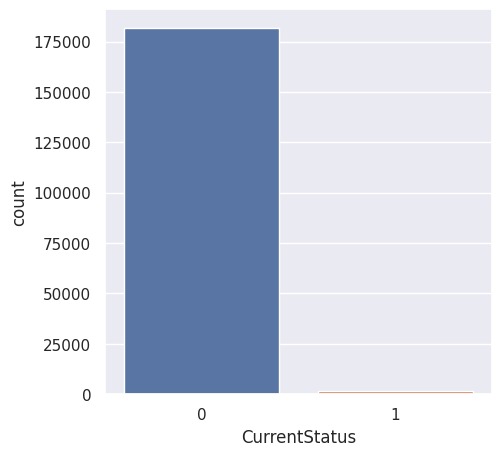

In [49]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.countplot(x=target, data=df);

In [50]:
df[target].value_counts() / df.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

## Missing values

### Creating features depicting whether an entry is missed or not


In [51]:
df.Plansets.value_counts()

2.0       84656
0.0       61869
3.0         247
4.0           3
6.0           2
9000.0        1
1.0           1
Name: Plansets, dtype: int64

there is an outlier, so lets drop it

In [52]:
df.drop(df.loc[df.Plansets == 9000].index, inplace=True)

---
Let's check whether the number of nans in the specific column correlates with the target variable





In [53]:
print("Completed date:")
print(df.loc[~df['CompletedDate'].notnull()].CurrentStatus.value_counts())
print()
print("Issued date:")
print(df.loc[df['IssuedDate'].notnull()].CurrentStatus.value_counts())
print()
print("First Construction Document date:")
print(df.loc[~df['FirstConstructionDocumentDate'].notnull()].CurrentStatus.value_counts())
print()
print("Number of Existing Stories:")
print(df.loc[df['NumberofExistingStories'].notnull()].CurrentStatus.value_counts())

print()
print("VoluntarySoft-StoryRetrofit:")
print(df.loc[~df['VoluntarySoft-StoryRetrofit'].isnull()].CurrentStatus.value_counts())

print()
print("Number of Existing Stories:")
print(df.loc[~df['FireOnlyPermit'].notnull()].CurrentStatus.value_counts())

print()
print("Number of Existing Stories:")
print(df.loc[~df['PermitExpirationDate'].notnull()].CurrentStatus.value_counts())

print()
print("Number of Existing Stories:")
print(df.loc[df['EstimatedCost'].notnull()].CurrentStatus.value_counts())

Completed date:
0    84762
1     1767
Name: CurrentStatus, dtype: int64

Issued date:
0    181152
1      1436
Name: CurrentStatus, dtype: int64

First Construction Document date:
0    803
1    343
Name: CurrentStatus, dtype: int64

Number of Existing Stories:
0    141160
1      1718
Name: CurrentStatus, dtype: int64

VoluntarySoft-StoryRetrofit:
0    29
Name: CurrentStatus, dtype: int64

Number of Existing Stories:
0    163702
1      1716
Name: CurrentStatus, dtype: int64

Number of Existing Stories:
0    37718
1      358
Name: CurrentStatus, dtype: int64

Number of Existing Stories:
0    144883
1      1764
Name: CurrentStatus, dtype: int64


New boolean features **CompletedDate_was_missing, IssuedDate_was_missing, FirstConstructionDocumentDate_was_missing**

In [54]:
df['CompletedDate_was_missing'] = df['CompletedDate'].isnull()
df['IssuedDate_was_missing'] = df['IssuedDate'].isnull()
df['FirstConstructionDocumentDate_was_missing'] = df['FirstConstructionDocumentDate'].isnull()
df['NumberofExistingStories_was_missing'] = df['NumberofExistingStories'].isnull()

df['NumberofStories_alteration'] = df['NumberofProposedStories'].fillna(0) - df['NumberofExistingStories'].fillna(0)

df['VoluntarySoft-StoryRetrofit_does_exist'] = df['VoluntarySoft-StoryRetrofit'].notnull()
df['FireOnlyPermit_does_exist'] = df['FireOnlyPermit'].notnull()
df['PermitExpirationDate_was_missing'] = df['PermitExpirationDate'].isnull()
df['EstimatedCost_was_missing'] = df['EstimatedCost'].isnull()

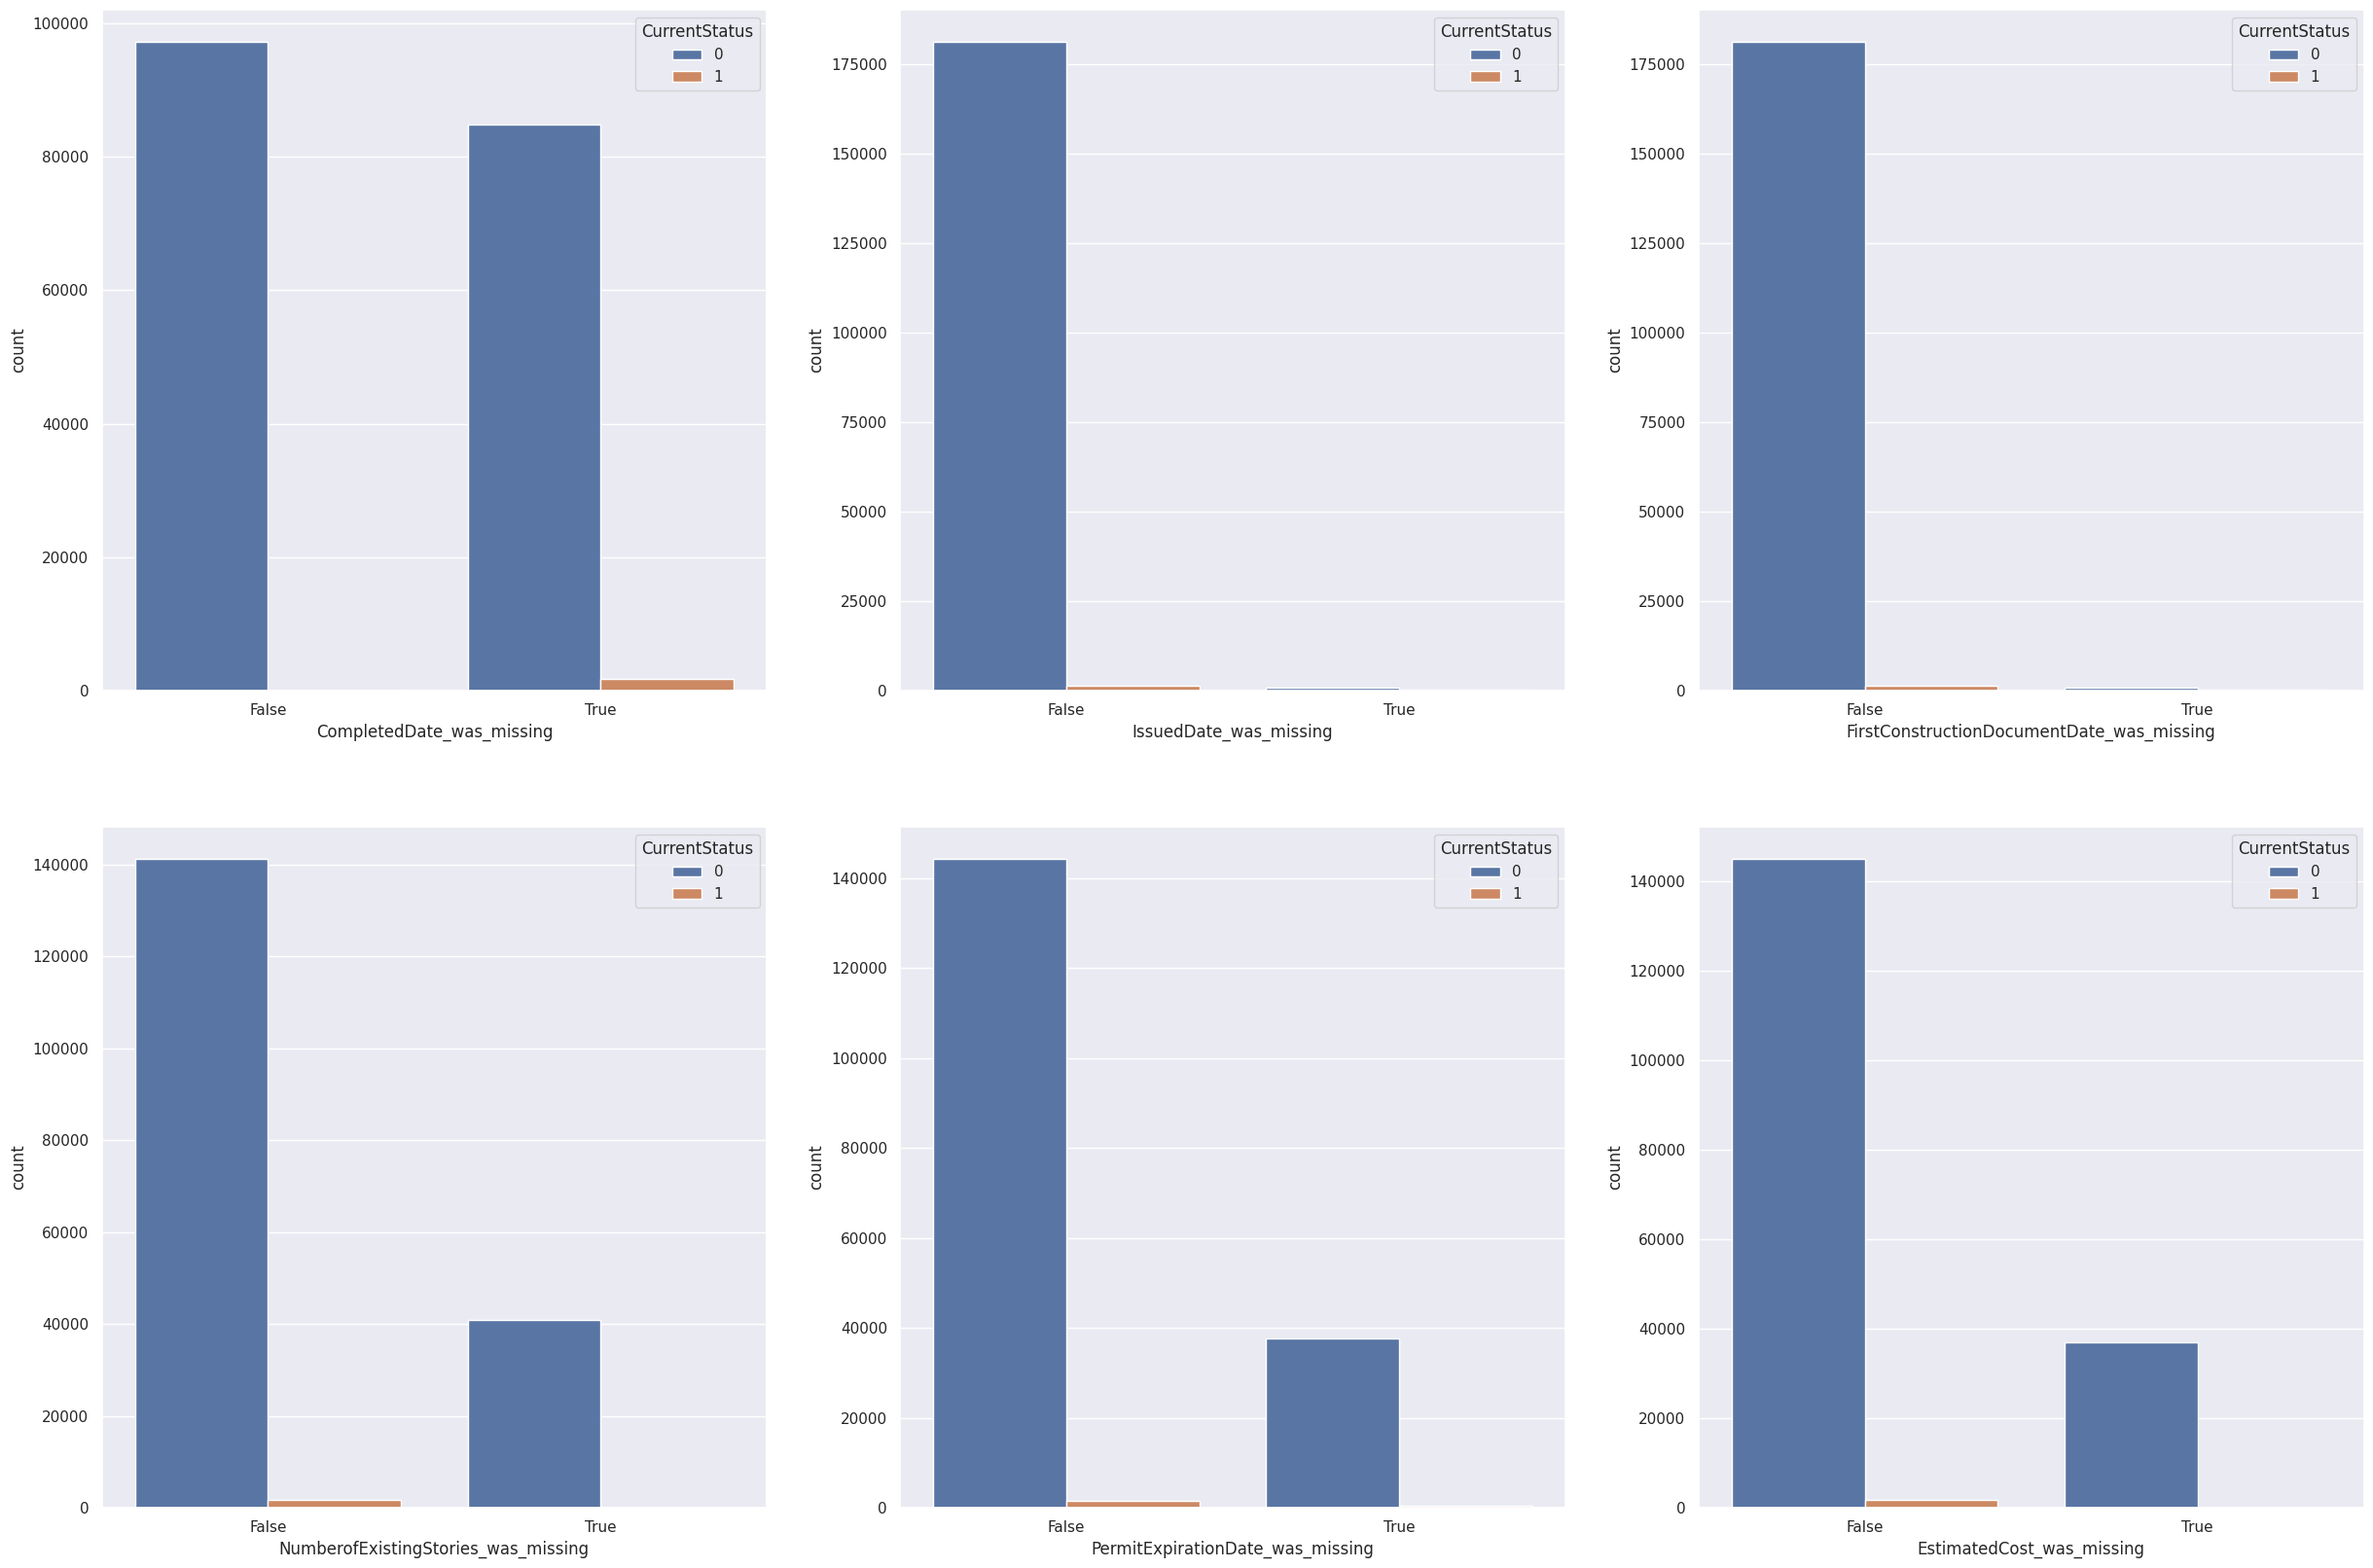

In [55]:
sns.set(rc={'figure.figsize':(30,20)})

fig, axs = plt.subplots(ncols=3, nrows=2)

k = 0
lst = [c for c in df.columns if 'was_missing' in c]

for i in range(0, 2):
    for j in range(0, 3):
        sns.countplot(x=lst[k], hue="CurrentStatus", data=df, ax=axs[i][j])
        k += 1

In [56]:
df.loc[df['StructuralNotification'] == 'Y'].CurrentStatus.value_counts(),  df.loc[df['StructuralNotification'] == 'N'].CurrentStatus.value_counts()

(0    5231
 1     136
 Name: CurrentStatus, dtype: int64,
 Series([], Name: CurrentStatus, dtype: int64))

In [57]:
df['StructuralNotification'] = df['StructuralNotification'].fillna('N')
df['StructuralNotification_is_yes'] = df['StructuralNotification'] == 'Y'

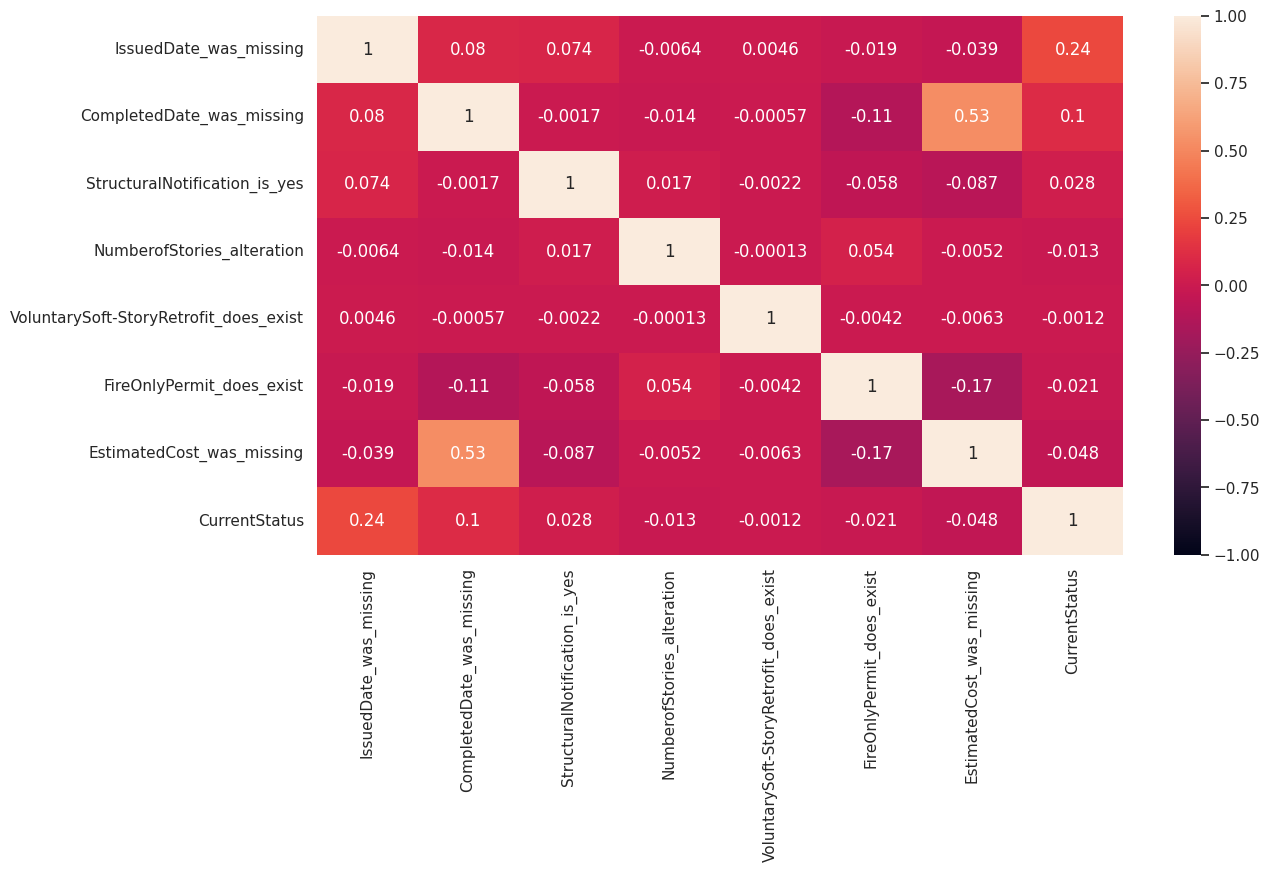

In [58]:
sns.set(rc={'figure.figsize':(13, 7)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist', 'EstimatedCost_was_missing', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

Let's remove nans from EstimatedCost

In [59]:
df1 = df[df['EstimatedCost'].notna()]

In [60]:
df1.shape

(146647, 53)

### Imputing missing data

fill in missing values in column RevisedCost using entries from EstimatedCost

In [61]:
df2 = df1
df2['RevisedCost'] = df2['RevisedCost'].fillna(df2['EstimatedCost'])

In [62]:
# new feature depicting change of estimated and real cost of total labor
df2['Cost_alteration'] = df2['RevisedCost'] - df2['EstimatedCost']

# fill in nans that doesn't actually exist and create feature that shows changes
b = df2['ExistingUse'].map(lambda x : (str(x)).lower().strip()).fillna("abacaba")
c = df2['ProposedUse'].map(lambda x : (str(x)).lower().strip()).fillna("abacaba")
df2["Use_was_altered"] = (b != c)

# the same with units of the building
df2['ExistingUnits'] = df2['ExistingUnits'].fillna(method='bfill')
df2['ProposedUnits'] = df2['ProposedUnits'].fillna(method='bfill')
df2['Units_alteration'] = df2['ProposedUnits'] - df2['ExistingUnits']

# literally the same with construction types
df2['ExistingConstructionTypeDescription'] = df2['ExistingConstructionTypeDescription'].fillna(method='bfill')
df2['ProposedConstructionTypeDescription'] = df2['ProposedConstructionTypeDescription'].fillna(method='bfill')
df2['ConstructionType_is_altered'] = df2['ProposedConstructionTypeDescription'] != df2['ExistingConstructionTypeDescription']

df2['Plansets'] = df2['Plansets'].fillna(method='ffill')
df2.drop(df2[(df2.Plansets == 4) | (df2.Plansets == 6) | (df2.Plansets == 1)].index, inplace=True)

# firstly replace nans with N and then map Y to True and N to Fasle
df2['SitePermit'] = df2['SitePermit'].fillna('N')
df2['SitePermit'] = df2['SitePermit'].map({'Y': True, 'N': False}).astype(bool)

# fill in nans simply with preceding value
df2['NumberofExistingStories'] = df2['NumberofExistingStories'].fillna(method='bfill')
df2['NumberofProposedStories'] = df2['NumberofProposedStories'].fillna(method='bfill') 

# fill in entries which don't exist
df2.Description = df2.Description.fillna("puk-srenk")
df2.ExistingUse = df2.ExistingUse.fillna('1 family dwelling')
df2.ProposedUse = df2.ExistingUse.fillna('1 family dwelling')

Let's drop nans from **SupervisorDistrict, Neighborhoods-AnalysisBoundaries, Zipcode**

In [63]:
df2 = df2[df2['SupervisorDistrict'].notna()]
df2 = df2[df2['Neighborhoods-AnalysisBoundaries'].notna()]
df2 = df2[df2['Zipcode'].notna()]

Now transform Location string to two new features: **Latitude and Longitude**

In [64]:
df2[['Location']].sample(2)

,Location
147987,"(37.76094969633071, -122.44935542538762)"
181040,"(37.759823906436026, -122.42171517514262)"


In [65]:
def coord1_parse(line):
    return [float(bit.rstrip(',')) for bit in line[1:-1].split()][0]

def coord2_parse(line):
    return [float(bit.rstrip(',')) for bit in line[1:-1].split()][1]

df2['Latitude'] = df2.Location.map(coord1_parse)
df2['Longitude'] = df2.Location.map(coord2_parse)

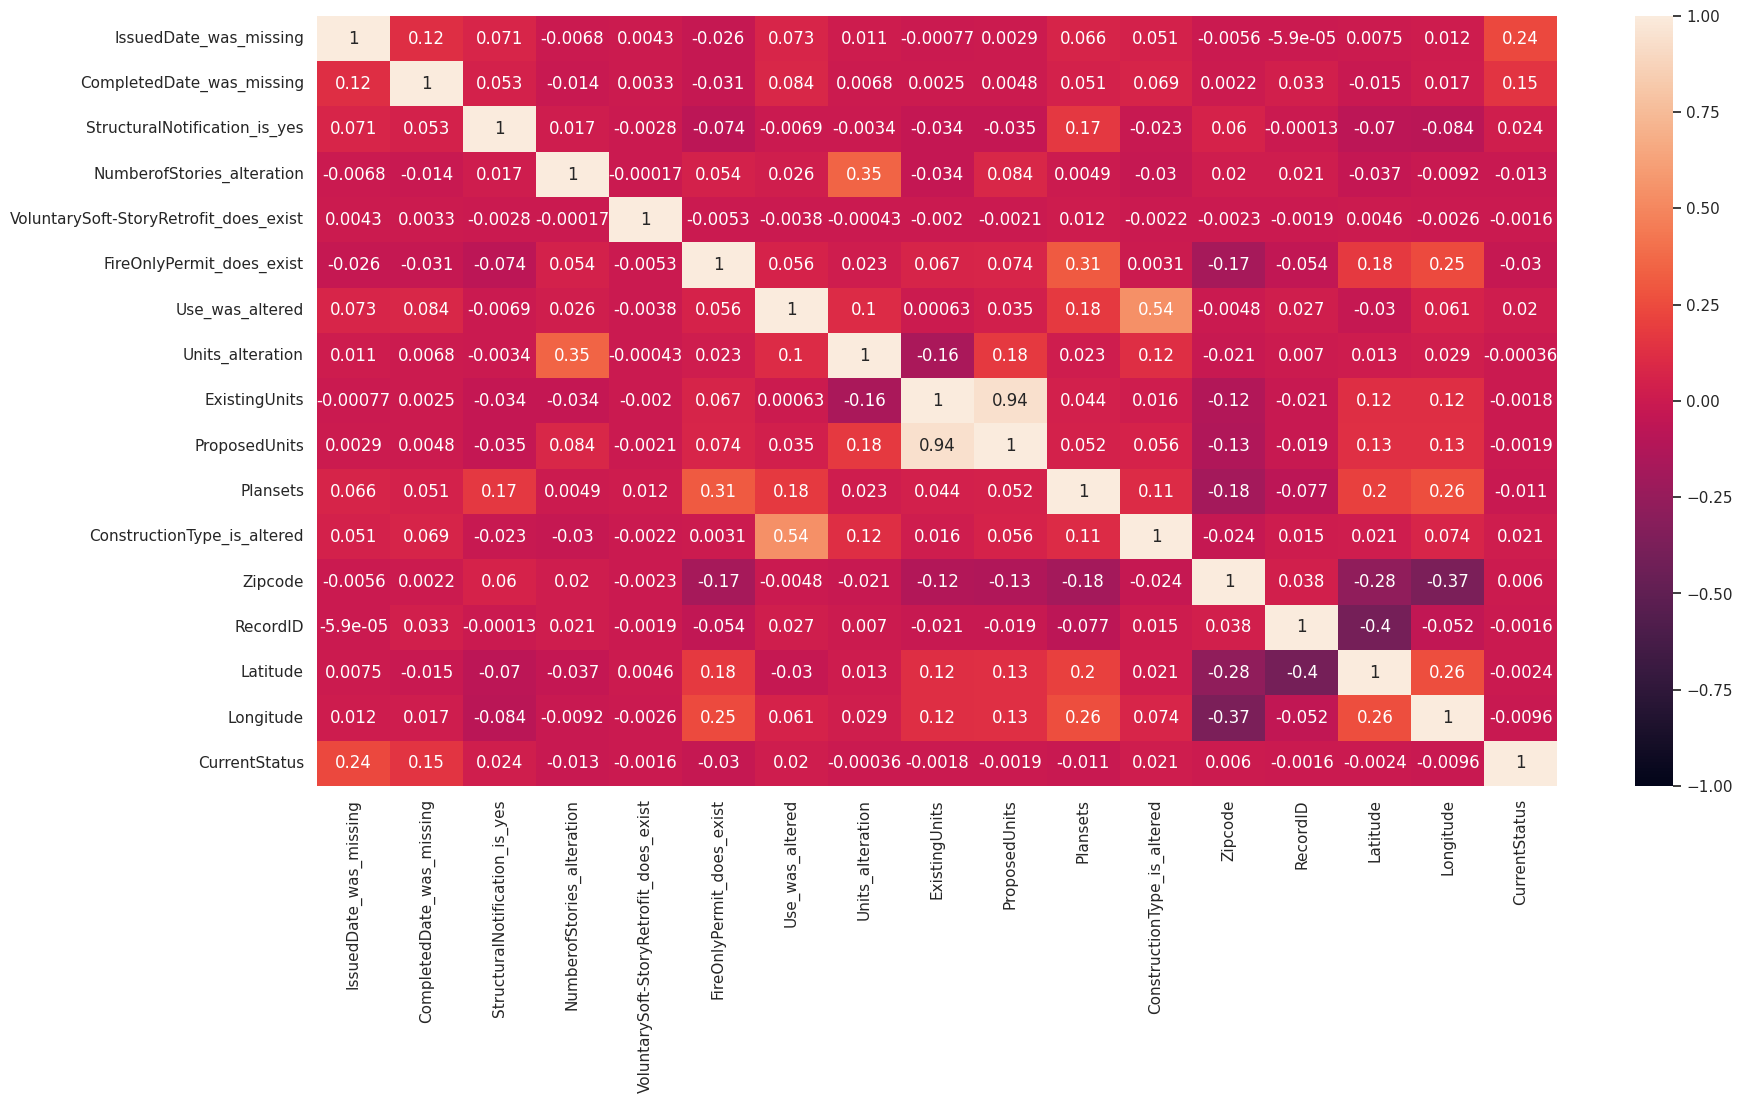

In [66]:
sns.set(rc={'figure.figsize':(20, 10)})

corr_matrix = df2[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes',
                   "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist',
                   'Use_was_altered', 'Units_alteration', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'ConstructionType_is_altered',
                   'Zipcode', 'RecordID', 'Latitude', 'Longitude', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

### Deleting useless columns

**columns to delete**: StreetNumberSuffix, Unit, UnitSuffix, CompletedDate (added binary feature), StructuralNotification (binary feature added), VoluntarySoft-StoryRetrofit (binary feature added), TIDFCompliance, ProposedConstructionType, ExistingConstructionType, RecordID

In [67]:
df_clean = df2.drop(['StreetNumberSuffix', 'Unit', 'UnitSuffix', 'CompletedDate',
                     'StructuralNotification', 'VoluntarySoft-StoryRetrofit',
                     'TIDFCompliance', 'ProposedConstructionType', 'ExistingConstructionType',
                     'FireOnlyPermit', 'RecordID', 'PermitNumber', 'PermitTypeDefinition', 'Location'], axis=1)

df_clean.StreetSuffix = df_clean.StreetSuffix.fillna(method='bfill')

In [68]:
df_clean.sample(3)

,PermitType,PermitCreationDate,Block,Lot,StreetNumber,StreetName,StreetSuffix,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,PermitExpirationDate,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,FirstConstructionDocumentDate_was_missing,NumberofExistingStories_was_missing,NumberofStories_alteration,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,PermitExpirationDate_was_missing,EstimatedCost_was_missing,StructuralNotification_is_yes,Cost_alteration,Use_was_altered,Units_alteration,ConstructionType_is_altered,Latitude,Longitude
191437,8,12/08/2017,0974,003,3108,Jackson,St,replace in rear north and west third floor bed...,0,12/08/2017,12/08/2017,12/08/2017,12/08/2017,3.0,3.0,04/08/2018,3000.0,3000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),False,2.0,Presidio Heights,94115.0,True,False,False,False,0.0,False,False,False,False,False,0.0,False,0.0,False,37.791229,-122.446458
101522,8,10/07/2015,1255,082,720,Ashbury,St,soft story retrofit,0,01/10/2017,10/07/2015,10/25/2016,10/25/2016,2.0,2.0,10/20/2017,30000.0,30000.0,apartments,6.0,apartments,6.0,2.0,wood frame (5),wood frame (5),False,5.0,Haight Ashbury,94117.0,False,False,False,False,0.0,False,False,False,False,False,0.0,False,0.0,False,37.768357,-122.446303
182032,8,09/12/2017,3544,092,293,Church,St,"repair landing (porch) at rear pt (wood), top ...",0,11/15/2017,09/12/2017,09/12/2017,09/12/2017,3.0,3.0,01/12/2018,4000.0,4000.0,apartments,4.0,apartments,4.0,0.0,wood frame (5),wood frame (5),False,8.0,Castro/Upper Market,94114.0,False,False,False,False,0.0,False,False,False,False,False,0.0,False,0.0,False,37.766282,-122.428561


## Handling dates

In [69]:
date_cols = [col for col in df_clean.columns if 'Date' in col and "was" not in col]

In [70]:
df_clean[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145580 entries, 1 to 198882
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   PermitCreationDate             145580 non-null  object
 1   CurrentStatusDate              145580 non-null  object
 2   FiledDate                      145580 non-null  object
 3   IssuedDate                     144462 non-null  object
 4   FirstConstructionDocumentDate  144440 non-null  object
 5   PermitExpirationDate           144469 non-null  object
dtypes: object(6)
memory usage: 7.8+ MB


Extract **day, month, year and timestamp (in seconds)** from the date columns and transform the initial column to datetime dtype

In [71]:
for c in ['IssuedDate', 'FirstConstructionDocumentDate', 'PermitExpirationDate']:
    df_clean[c] = df_clean[c].fillna(method='bfill') 

for c in date_cols:
    df_clean[c + '_day'] = pd.to_datetime(df_clean[c], format='%m/%d/%Y').dt.day
    df_clean[c + '_month'] = pd.to_datetime(df_clean[c], format='%m/%d/%Y').dt.month
    df_clean[c + '_year'] = pd.to_datetime(df_clean[c], format='%m/%d/%Y').dt.year
    df_clean[c] = pd.to_datetime(df_clean[c], format='%m/%d/%Y')
    df_clean[c + '_seconds'] = df_clean[c].astype(int)

<Axes: xlabel='IssuedDate_month', ylabel='count'>

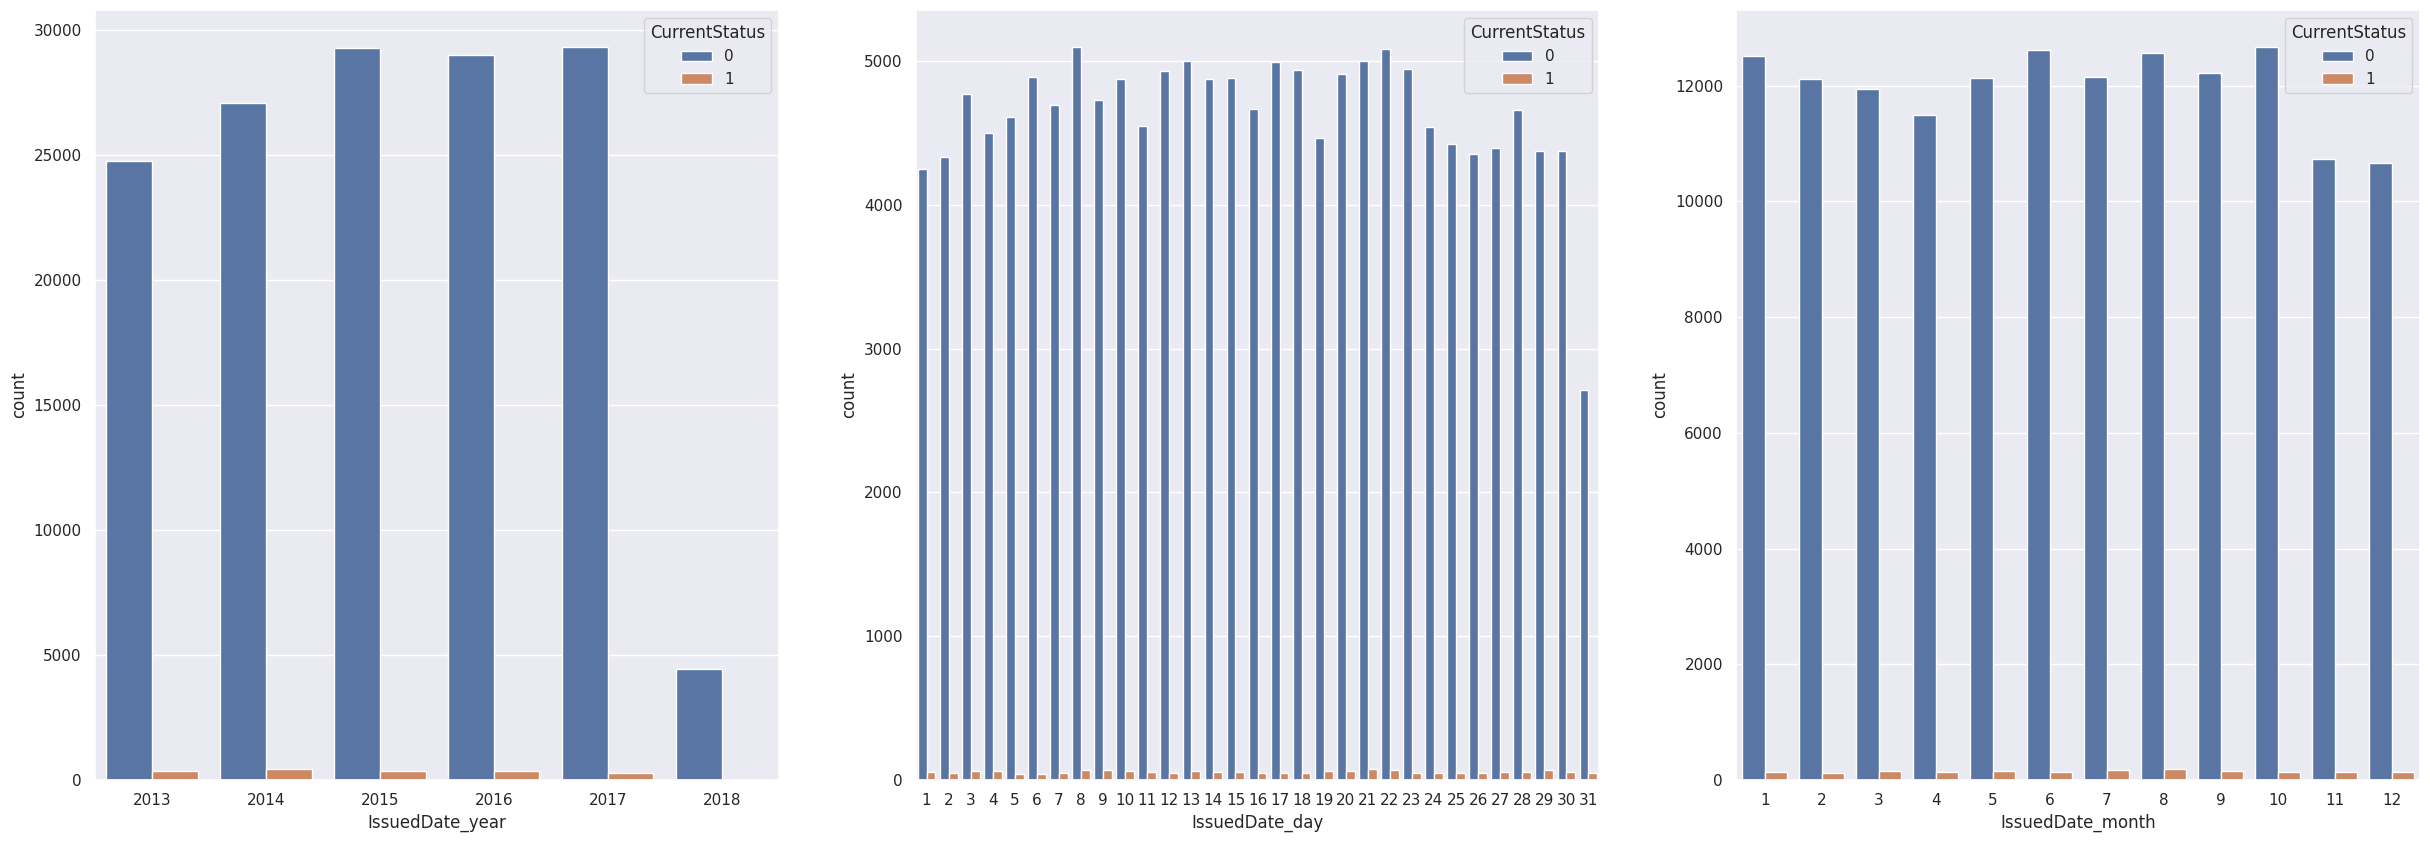

In [73]:
sns.set(rc={'figure.figsize':(30, 10)})

fig, axs = plt.subplots(ncols=3)
sns.countplot(x="IssuedDate_year", hue="CurrentStatus", data=df_clean, ax=axs[0])
sns.countplot(x="IssuedDate_day", hue="CurrentStatus", data=df_clean, ax=axs[1])
sns.countplot(x="IssuedDate_month", hue="CurrentStatus", data=df_clean, ax=axs[2])

In [74]:
date_cols_day = [col for col in df_clean.columns if 'Date' in col and "day" in col]
date_cols_month = [col for col in df_clean.columns if 'Date' in col and "month" in col]
date_cols_year = [col for col in df_clean.columns if 'Date' in col and "year" in col]
date_cols_seconds = [col for col in df_clean.columns if 'Date' in col and "seconds" in col]

In [75]:
for c in date_cols_day + date_cols_month + date_cols_year:
    df_clean[c] = df_clean[c].astype('O') 

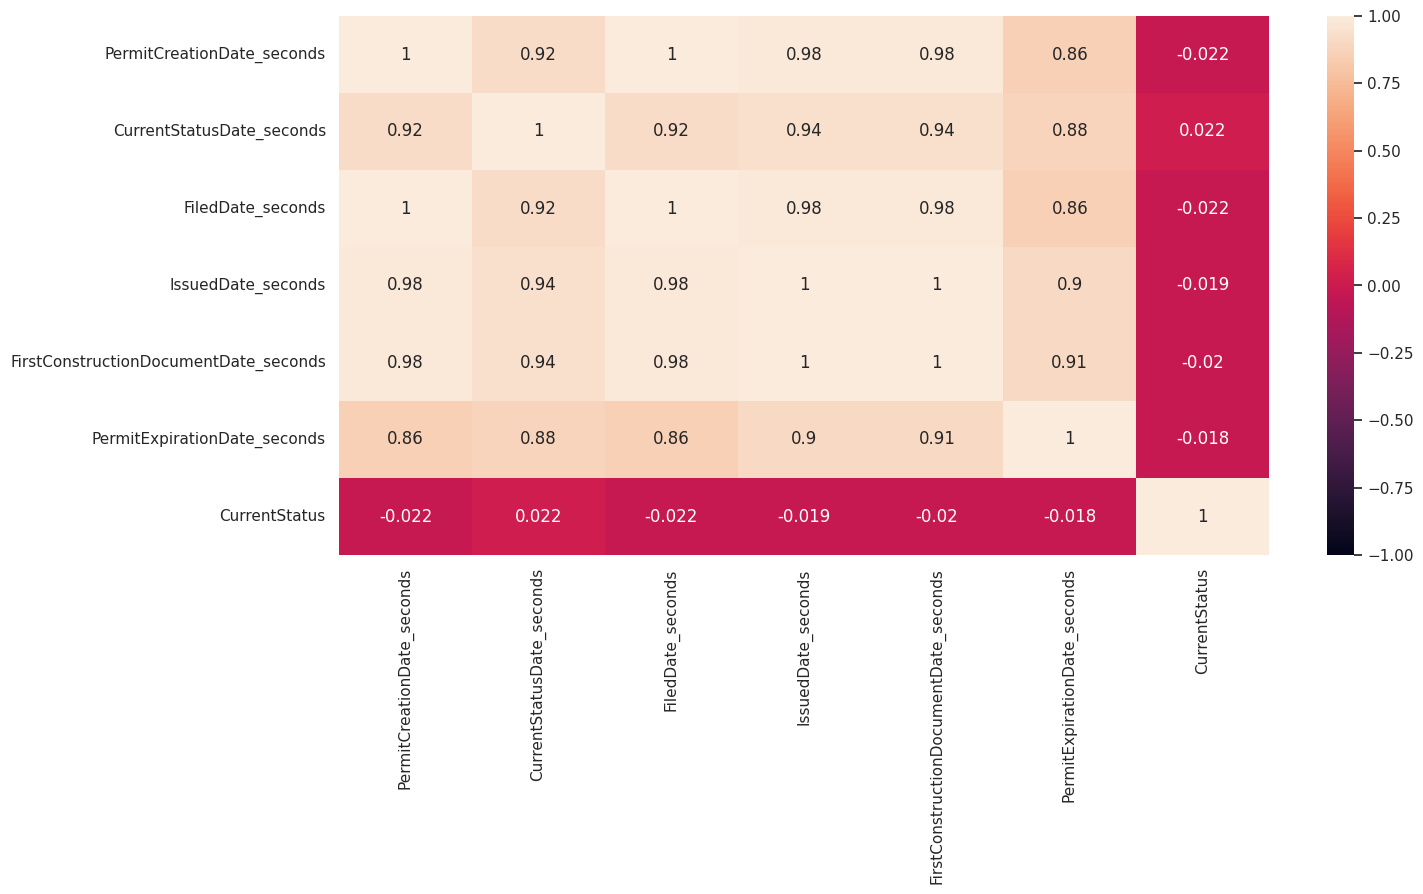

In [76]:
sns.set(rc={'figure.figsize':(15, 7)})

corr_matrix = df_clean[date_cols_seconds + [target]].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [77]:
df_clean.drop(date_cols, axis=1, inplace=True)

In [78]:
df_clean.drop(['Description'], axis=1, inplace=True)

# Feature engineering

In [81]:
X = df_clean.copy()
y = X.pop('CurrentStatus')

In [82]:
X.sample(3)

,PermitType,Block,Lot,StreetNumber,StreetName,StreetSuffix,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,FirstConstructionDocumentDate_was_missing,NumberofExistingStories_was_missing,NumberofStories_alteration,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,PermitExpirationDate_was_missing,EstimatedCost_was_missing,StructuralNotification_is_yes,Cost_alteration,Use_was_altered,Units_alteration,ConstructionType_is_altered,Latitude,Longitude,PermitCreationDate_day,PermitCreationDate_month,PermitCreationDate_year,PermitCreationDate_seconds,CurrentStatusDate_day,CurrentStatusDate_month,CurrentStatusDate_year,CurrentStatusDate_seconds,FiledDate_day,FiledDate_month,FiledDate_year,FiledDate_seconds,IssuedDate_day,IssuedDate_month,IssuedDate_year,IssuedDate_seconds,FirstConstructionDocumentDate_day,FirstConstructionDocumentDate_month,FirstConstructionDocumentDate_year,FirstConstructionDocumentDate_seconds,PermitExpirationDate_day,PermitExpirationDate_month,PermitExpirationDate_year,PermitExpirationDate_seconds
31138,8,3779,003,520,06th,St,4.0,4.0,30000.0,30000.0,artist live/work,24.0,artist live/work,24.0,0.0,wood frame (5),wood frame (5),False,6.0,South of Market,94103.0,False,False,False,False,0.0,False,False,False,False,False,0.0,False,0.0,False,37.775459,-122.402357,14,11,2013,1384387200000000000,8,5,2014,1399507200000000000,14,11,2013,1384387200000000000,14,11,2013,1384387200000000000,14,11,2013,1384387200000000000,9,11,2014,1415491200000000000
168717,8,4088,005,816,Hampshire,St,2.0,2.0,15000.0,28000.0,apartments,3.0,apartments,3.0,0.0,wood frame (5),wood frame (5),False,9.0,Mission,94110.0,False,False,False,False,0.0,False,False,False,False,False,13000.0,False,0.0,False,37.758681,-122.408124,16,5,2017,1494892800000000000,14,8,2017,1502668800000000000,16,5,2017,1494892800000000000,16,5,2017,1494892800000000000,16,5,2017,1494892800000000000,11,5,2018,1525996800000000000
142374,4,0040,017,295,Bay,St,4.0,1.0,4000.0,4000.0,retail sales,1.0,retail sales,1.0,2.0,constr type 2,wood frame (5),False,3.0,North Beach,94133.0,True,False,False,False,-4.0,False,False,False,False,False,0.0,True,0.0,True,37.805547,-122.411614,14,11,2016,1479081600000000000,15,11,2016,1479168000000000000,14,11,2016,1479081600000000000,15,11,2016,1479168000000000000,15,11,2016,1479168000000000000,10,11,2017,1510272000000000000


In [83]:
X.Zipcode = X.Zipcode.astype('O')
X.PermitType = X.PermitType.astype('O')
X.StreetNumber = X.StreetNumber.astype('O')
X.Plansets = X.Plansets.astype('O')
X.SupervisorDistrict = X.SupervisorDistrict.astype('O')

In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145580 entries, 1 to 198882
Data columns (total 61 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   PermitType                                 145580 non-null  object 
 1   Block                                      145580 non-null  object 
 2   Lot                                        145580 non-null  object 
 3   StreetNumber                               145580 non-null  object 
 4   StreetName                                 145580 non-null  object 
 5   StreetSuffix                               145580 non-null  object 
 6   NumberofExistingStories                    145580 non-null  float64
 7   NumberofProposedStories                    145580 non-null  float64
 8   EstimatedCost                              145580 non-null  float64
 9   RevisedCost                                145580 non-null  float64
 10  Existing

In [85]:
X.replace({False: 0, True: 1}, inplace=True)

In [86]:
from sklearn.feature_selection import mutual_info_classif

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

<ipython-input-86-4fc31734619c>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Create feature representing amount of time between creation and getting current status of application

In [87]:
X['CreationToCurrent_duration'] = (X.CurrentStatusDate_seconds - X.PermitCreationDate_seconds)

Distribution of positive and negative values on map (latitude, longitude)

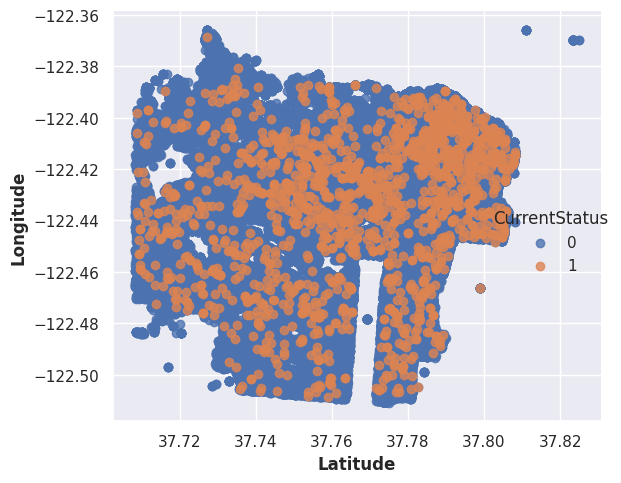

In [88]:
sns.set(rc={'figure.figsize':(20, 10)})

sns.lmplot(data=pd.concat([X, pd.DataFrame(y)], axis=1), x="Latitude", y="Longitude", hue=target, fit_reg=False);

New Feature representing distance from the centre to the specific point on a grid with longitude-latitude coordinates

In [92]:
from sklearn.preprocessing import StandardScaler
pca1 = StandardScaler()
X[['Latitude', 'Longitude']] = pca1.fit_transform(X[['Latitude', 'Longitude']])

In [93]:
X['DistanceFromCentre'] = (X['Latitude'] ** 2 + X['Longitude'] ** 2) ** (1/2)

Lets compute mutual information between target and any other features

In [94]:
mi_scores = make_mi_scores(X, y)

Plansets                                     0.026423
Block                                        0.016081
CurrentStatusDate_seconds                    0.015381
CompletedDate_was_missing                    0.012662
CreationToCurrent_duration                   0.012413
StreetNumber                                 0.012102
PermitExpirationDate_seconds                 0.008610
PermitCreationDate_seconds                   0.007475
FiledDate_seconds                            0.007466
FirstConstructionDocumentDate_seconds        0.007205
IssuedDate_seconds                           0.007125
PermitExpirationDate_was_missing             0.005989
IssuedDate_was_missing                       0.005971
FirstConstructionDocumentDate_was_missing    0.005918
Longitude                                    0.005852
StreetName                                   0.005645
Latitude                                     0.005596
DistanceFromCentre                           0.004782
SupervisorDistrict          

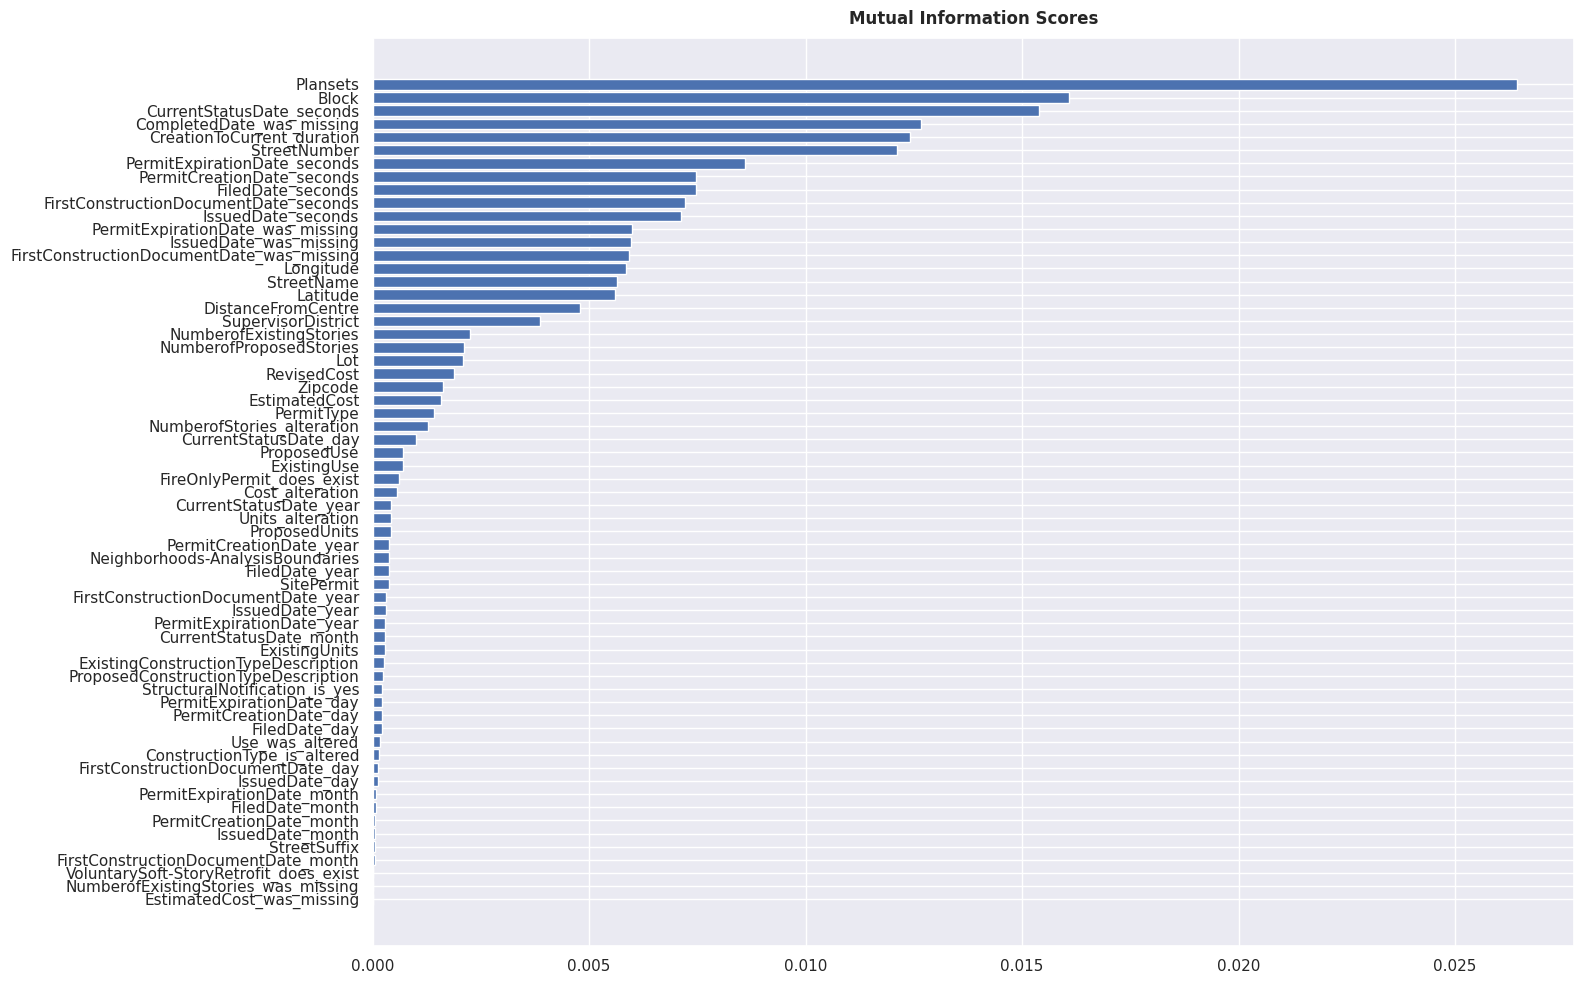

In [95]:
print(mi_scores.head(50))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(16, 10))
plot_mi_scores(mi_scores)
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [96]:
X.sample()

,PermitType,Block,Lot,StreetNumber,StreetName,StreetSuffix,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,FirstConstructionDocumentDate_was_missing,NumberofExistingStories_was_missing,NumberofStories_alteration,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,PermitExpirationDate_was_missing,EstimatedCost_was_missing,StructuralNotification_is_yes,Cost_alteration,Use_was_altered,Units_alteration,ConstructionType_is_altered,Latitude,Longitude,PermitCreationDate_day,PermitCreationDate_month,PermitCreationDate_year,PermitCreationDate_seconds,CurrentStatusDate_day,CurrentStatusDate_month,CurrentStatusDate_year,CurrentStatusDate_seconds,FiledDate_day,FiledDate_month,FiledDate_year,FiledDate_seconds,IssuedDate_day,IssuedDate_month,IssuedDate_year,IssuedDate_seconds,FirstConstructionDocumentDate_day,FirstConstructionDocumentDate_month,FirstConstructionDocumentDate_year,FirstConstructionDocumentDate_seconds,PermitExpirationDate_day,PermitExpirationDate_month,PermitExpirationDate_year,PermitExpirationDate_seconds,CreationToCurrent_duration,DistanceFromCentre
97444,8,0825,039,411,Pierce,St,4.0,4.0,18000.0,33000.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),0,5.0,Hayes Valley,94117.0,0,0,0,0,0.0,0,0,0,0,0,15000.0,0,0.0,0,0.241492,-0.093724,2,9,2015,1441152000000000000,18,11,2015,1447804800000000000,2,9,2015,1441152000000000000,2,9,2015,1441152000000000000,2,9,2015,1441152000000000000,27,8,2016,1472256000000000000,6652800000000000,0.259041


# Models 

## Settings

In [97]:
def get_scores(clf, X, y, threshold_start, threshold_end, threshold_step):
    ra = roc_auc_score(y, (clf.predict_proba(X)[:,1]))
    print(f'Default roc-auc = {ra * 100:.3f}%')
    f1s = f1_score(y, (clf.predict(X)))
    print(f'Default f1 = {f1s * 100:.3f}%')
    print()

    for threshold in np.arange(threshold_start, threshold_end, threshold_step):
        aucScore       = roc_auc_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))
        recallScore    = recall_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))
        precisionScore = precision_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))
        f1Score        = f1_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))

        print(f'threshold = {threshold:.3f}:')
        print(f'    roc-auc = {aucScore * 100:.3f}%')
        print(f'    recall = {recallScore * 100:.3f}%')
        print(f'    precision = {precisionScore * 100:.3f}%')
        print(f'    f1 = {f1Score * 100:.3f}%')
        print()

In [98]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.5 MB/s eta 0:00:00


In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

from catboost import CatBoostClassifier, Pool, metrics, cv

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## CatBoost

### Default Catboost

In [101]:
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

In [102]:
cat_cols

['Block',
 'Lot',
 'StreetName',
 'StreetSuffix',
 'ExistingUse',
 'ProposedUse',
 'ExistingConstructionTypeDescription',
 'ProposedConstructionTypeDescription',
 'Neighborhoods-AnalysisBoundaries']

In [103]:
X_valid_cbc, X_test_cbc, y_valid_cbc, y_test_cbc = train_test_split(X_test, y_test, test_size=0.5)

In [104]:
params = {
    'loss_function' : 'Logloss',
    'eval_metric' : 'F1',
    'verbose' : 200,
    'random_seed' : 42,
    'custom_metric' : 'AUC:hints=skip_train~false'
}

cbc = CatBoostClassifier(**params)
cbc.fit(X_train, y_train,
        cat_features=cat_cols,
        eval_set = (X_valid_cbc, y_valid_cbc),
        use_best_model = True
);

Learning rate set to 0.101003
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 358ms	remaining: 5m 57s
200:	learn: 0.8675283	test: 0.8046512	best: 0.8065268 (190)	total: 1m 24s	remaining: 5m 33s
400:	learn: 0.9202024	test: 0.8246014	best: 0.8246014 (378)	total: 2m 28s	remaining: 3m 41s
600:	learn: 0.9496348	test: 0.8216704	best: 0.8253968 (404)	total: 3m 31s	remaining: 2m 20s
800:	learn: 0.9736742	test: 0.8306998	best: 0.8333333 (777)	total: 4m 33s	remaining: 1m 7s
999:	learn: 0.9828441	test: 0.8356164	best: 0.8363636 (956)	total: 5m 35s	remaining: 0us

bestTest = 0.8363636364
bestIteration = 956

Shrink model to first 957 iterations.


In [105]:
get_scores(cbc, X_test_cbc, y_test_cbc, 0.1, 1.0, 0.1)

Default roc-auc = 99.394%
Default f1 = 84.399%

threshold = 0.100:
    roc-auc = 94.934%
    recall = 90.196%
    precision = 75.720%
    f1 = 82.327%

threshold = 0.200:
    roc-auc = 92.770%
    recall = 85.784%
    precision = 79.909%
    f1 = 82.742%

threshold = 0.300:
    roc-auc = 92.074%
    recall = 84.314%
    precision = 85.149%
    f1 = 84.729%

threshold = 0.400:
    roc-auc = 91.104%
    recall = 82.353%
    precision = 86.598%
    f1 = 84.422%

threshold = 0.500:
    roc-auc = 90.380%
    recall = 80.882%
    precision = 88.235%
    f1 = 84.399%

threshold = 0.600:
    roc-auc = 89.185%
    recall = 78.431%
    precision = 93.567%
    f1 = 85.333%

threshold = 0.700:
    roc-auc = 85.509%
    recall = 71.078%
    precision = 92.949%
    f1 = 80.556%

threshold = 0.800:
    roc-auc = 82.826%
    recall = 65.686%
    precision = 95.714%
    f1 = 77.907%

threshold = 0.900:
    roc-auc = 76.459%
    recall = 52.941%
    precision = 96.429%
    f1 = 68.354%



### catboost grid_search (+1% to f1 score) 

In [ ]:
datapool = Pool(data=X_train, label=y_train, cat_features=cat_cols)

fix_params = {
    'loss_function' : 'Logloss',
    'eval_metric' : 'F1',
    'verbose' : 200,
    'random_seed' : 42,
    'custom_metric' : 'F1:hints=skip_train~false'
}

params = {
    "learning_rate": [0.1, 0.15],
    "max_depth": [4, 6, 8, 10]
}

cat = CatBoostClassifier(**fix_params)
scores = cat.grid_search(params, datapool, cv=3)

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 72.3ms	remaining: 1m 12s
200:	learn: 0.7907972	test: 0.7069351	best: 0.7155556 (182)	total: 49.4s	remaining: 3m 16s
400:	learn: 0.8530319	test: 0.7483589	best: 0.7527352 (348)	total: 1m 36s	remaining: 2m 23s
600:	learn: 0.8856275	test: 0.7602592	best: 0.7645788 (592)	total: 2m 24s	remaining: 1m 35s
800:	learn: 0.9065467	test: 0.7751606	best: 0.7820513 (699)	total: 3m 13s	remaining: 48s
999:	learn: 0.9235353	test: 0.7837259	best: 0.7837259 (994)	total: 4m	remaining: 0us

bestTest = 0.7837259101
bestIteration = 994

0:	loss: 0.7837259	best: 0.7837259 (0)	total: 4m	remaining: 28m 4s
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 66.7ms	remaining: 1m 6s
200:	learn: 0.8240209	test: 0.7439825	best: 0.7456140 (195)	total: 47s	remaining: 3m 6s
400:	learn: 0.8829194	test: 0.7500000	best: 0.7592191 (235)	total: 1m 35s	remaining: 2m 21s
600:	learn: 0.9172483	test: 0.7777778	best: 0.7803838 (595)	total: 2m 23s	remaining

In [ ]:
cat.best_score_

{'learn': {'Logloss': 0.0004281674911157638, 'F1': 1.0}}

In [ ]:
get_scores(cat, X_test, y_test, 0.1, 1.0, 0.1)

Basic roc-auc = 99.163%

threshold = 0.100:
    roc-auc = 95.958%
    recall = 92.174%
    precision = 82.012%
    f1 = 86.796%

threshold = 0.200:
    roc-auc = 94.250%
    recall = 88.696%
    precision = 85.356%
    f1 = 86.994%

threshold = 0.300:
    roc-auc = 93.184%
    recall = 86.522%
    precision = 87.859%
    f1 = 87.185%

threshold = 0.400:
    roc-auc = 92.436%
    recall = 85.000%
    precision = 89.474%
    f1 = 87.179%

threshold = 0.500:
    roc-auc = 91.466%
    recall = 83.043%
    precision = 90.521%
    f1 = 86.621%

threshold = 0.600:
    roc-auc = 90.386%
    recall = 80.870%
    precision = 91.400%
    f1 = 85.813%

threshold = 0.700:
    roc-auc = 88.654%
    recall = 77.391%
    precision = 92.228%
    f1 = 84.161%

threshold = 0.800:
    roc-auc = 86.820%
    recall = 73.696%
    precision = 94.429%
    f1 = 82.784%

threshold = 0.900:
    roc-auc = 83.892%
    recall = 67.826%
    precision = 95.413%
    f1 = 79.288%



## RF (in progress)

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

In [ ]:
#rf_clf = RandomForestClassifier(n_estimators=300, random_state=13)

In [ ]:
#rf_clf.fit(X_fe_train, y_train)

In [ ]:
#get_scores(rf_clf, X_fe_test, y_test, 0.1, 0.7, 0.1)

## Linear Models and neural nets (work in progress)



### Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_clean[num_cols + cat_cols], df_clean[target], test_size=0.3)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((101906, 28), (43674, 28), (101906,), (43674,))

In [ ]:
pca1 = StandardScaler()
pca2 = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled[num_cols] = pca1.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = pca2.fit_transform(X_test_scaled[num_cols])

#### preprocessing -- categorical features

##### too much unique values => not one hot encoding

In [38]:
def replace_by_other(a, d, boundary):
    if (d[a] < boundary):
        return 'other'
    else:
        return a

In [ ]:
X_train_scaled.StreetSuffix.value_counts().loc[X_train_scaled.StreetSuffix.value_counts() < 1000].sum()

2333

In [ ]:
X_test_scaled.StreetSuffix.value_counts(), X_train_scaled.StreetSuffix.value_counts()

(St    30260
 Av     9857
 Wy      917
 Dr      841
 Bl      775
 Tr      357
 Ct      163
 Pl      130
 Ln       91
 Rd       86
 Hy       64
 Pz       58
 Cr       25
 Pk       24
 Al       23
 Wk        2
 Rw        1
 Name: StreetSuffix, dtype: int64,
 St    70445
 Av    23220
 Wy     2095
 Dr     1931
 Bl     1882
 Tr      779
 Ct      438
 Pl      259
 Rd      211
 Ln      202
 Pz      135
 Hy      127
 Pk       70
 Cr       57
 Al       38
 Wk        8
 Rw        3
 So        2
 No        2
 Sw        1
 Hl        1
 Name: StreetSuffix, dtype: int64)

In [ ]:
X_train_scaled.StreetSuffix.value_counts().loc[X_train_scaled.StreetSuffix.value_counts() < 1000].sum(), X_test_scaled.StreetSuffix.value_counts().loc[X_test_scaled.StreetSuffix.value_counts() < 500].sum()

(2333, 1024)

In [ ]:
X_train_scaled_cat = X_train_scaled
d1_train = X_train_scaled.StreetSuffix.value_counts()
X_train_scaled_cat.StreetSuffix = X_train_scaled.StreetSuffix.map(lambda x : replace_by_other(x, d1_train, 1000))

X_test_scaled_cat = X_test_scaled
d1_test = X_test_scaled.StreetSuffix.value_counts()
X_test_scaled_cat.StreetSuffix = X_test_scaled.StreetSuffix.map(lambda x : replace_by_other(x, d1_test, 500))

In [ ]:
X_test_scaled_cat.PermitType.value_counts(), X_train_scaled_cat.PermitType.value_counts()

(8    39373
 3     3040
 4      751
 2      187
 7      121
 6      118
 1       55
 5       29
 Name: PermitType, dtype: int64,
 8    91868
 3     7163
 4     1680
 2      444
 6      303
 7      257
 1      136
 5       55
 Name: PermitType, dtype: int64)

In [ ]:
X_train_scaled_cat['Neighborhoods-AnalysisBoundaries'].value_counts()

Financial District/South Beach    13285
Mission                            6982
Sunset/Parkside                    5853
West of Twin Peaks                 5029
Castro/Upper Market                4144
South of Market                    4070
Outer Richmond                     4014
Noe Valley                         3852
Marina                             3833
Pacific Heights                    3716
Bernal Heights                     3120
Bayview Hunters Point              3101
Inner Sunset                       2992
Haight Ashbury                     2695
Nob Hill                           2644
Hayes Valley                       2556
Tenderloin                         2544
Russian Hill                       2456
Potrero Hill                       2173
Inner Richmond                     2123
Western Addition                   2037
Chinatown                          1979
North Beach                        1928
Presidio Heights                   1892
Excelsior                          1752


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 5.0 MB/s eta 0:00:00


In [ ]:
from category_encoders import TargetEncoder

In [ ]:
tgt_enc1 = TargetEncoder()
tgt_enc2 = TargetEncoder()
X_train_scaled_cat['Neighborhoods-AnalysisBoundaries'] = tgt_enc1.fit_transform(X_train_scaled_cat['Neighborhoods-AnalysisBoundaries'], y_train)
X_test_scaled_cat['Neighborhoods-AnalysisBoundaries'] = tgt_enc2.fit_transform(X_test_scaled_cat['Neighborhoods-AnalysisBoundaries'], y_test)

In [ ]:
X_train_scaled_cat['Zipcode'] = X_train_scaled_cat['Zipcode'].astype('O')
X_test_scaled_cat['Zipcode']  = X_test_scaled_cat['Zipcode'].astype('O')

X_train_scaled_cat['Zipcode'] = tgt_enc1.fit_transform(X_train_scaled_cat['Zipcode'], y_train)
X_test_scaled_cat['Zipcode'] = tgt_enc2.fit_transform(X_test_scaled_cat['Zipcode'], y_test)

In [ ]:
X_train_scaled_cat.PermitType.value_counts(), X_test_scaled_cat.PermitType.value_counts()

(8    91868
 3     7163
 4     1680
 2      444
 6      303
 7      257
 1      136
 5       55
 Name: PermitType, dtype: int64,
 8    39373
 3     3040
 4      751
 2      187
 7      121
 6      118
 1       55
 5       29
 Name: PermitType, dtype: int64)

In [ ]:
X_train_scaled_cat.PermitType.value_counts().loc[X_train_scaled_cat.PermitType.value_counts() < 1000].sum(), X_test_scaled_cat.PermitType.value_counts().loc[X_test_scaled_cat.PermitType.value_counts() < 500].sum()

(1195, 510)

In [ ]:
d_train = X_train_scaled_cat.PermitType.value_counts()
d_test = X_test_scaled_cat.PermitType.value_counts()

In [ ]:
X_train_scaled_cat.PermitType = X_train_scaled_cat.PermitType.map(lambda x : replace_by_other(x, d_train, 1000))
X_test_scaled_cat.PermitType = X_test_scaled_cat.PermitType.map(lambda x : replace_by_other(x, d_test, 500))

In [ ]:
X_train_scaled_cat.SupervisorDistrict.value_counts()

3     15024
6     14062
8     13132
2     11617
5      9180
7      8342
9      8183
1      6520
10     6456
4      5467
11     3923
Name: SupervisorDistrict, dtype: int64

In [ ]:
X_test_scaled_cat.SupervisorDistrict.value_counts()

3     6548
6     5922
8     5604
2     4961
5     3928
7     3614
9     3527
1     2739
10    2705
4     2444
11    1682
Name: SupervisorDistrict, dtype: int64

In [ ]:
num_cols_after_cat = [
    'NumberofExistingStories',
    'NumberofProposedStories',
    'EstimatedCost',
    'RevisedCost',
    'ExistingUnits',
    'ProposedUnits',
    'NumberofStories_alteration',
    'Cost_alteration',
    'Units_alteration',
    'Latitude',
    'Longitude',
    'Neighborhoods-AnalysisBoundaries',
    'Zipcode',
]

##### one hot encoding 

In [ ]:
cols_to_ohe = ['PermitType', 'StreetSuffix', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'SupervisorDistrict', 'Plansets']
X_train_scaled_cat_ohe = pd.get_dummies(X_train_scaled_cat, columns=cols_to_ohe)
X_test_scaled_cat_ohe = pd.get_dummies(X_test_scaled_cat, columns=cols_to_ohe)

In [ ]:
X_train_scaled_cat_ohe.replace({False: 0, True: 1}, inplace=True)
X_test_scaled_cat_ohe.replace({False: 0, True: 1}, inplace=True)

In [ ]:
pca1 = StandardScaler()
pca2 = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled[num_cols] = pca1.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = pca2.fit_transform(X_test_scaled[num_cols])